<a href="https://colab.research.google.com/github/AdityaaRavi/Butterfly-cnn/blob/preprocessing/Butteryfly_cnn_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the data

## downloading

In [47]:
!mkdir /content/butterfly-data

mkdir: cannot create directory ‘/content/butterfly-data’: File exists


In [48]:
# get the kaggle api token
!mkdir ~/.kaggle
file_id = "1zSRznA3TypBwqP75WcOuv6X3tbaYDiNJ"
file_download_link = "https://docs.google.com/uc?export=download&id=" + file_id
!wget -O ~/.kaggle/kaggle.json --no-check-certificate "$file_download_link"
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list > datasets.txt
!head 5 datasets.txt
!pip install tensorflow_io

mkdir: cannot create directory ‘/root/.kaggle’: File exists
--2022-11-24 23:00:01--  https://docs.google.com/uc?export=download&id=1zSRznA3TypBwqP75WcOuv6X3tbaYDiNJ
Resolving docs.google.com (docs.google.com)... 108.177.119.102, 108.177.119.113, 108.177.119.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mfufrik8c6efl8r5a37in9ko3qs8m1t5/1669330800000/09300047399178709700/*/1zSRznA3TypBwqP75WcOuv6X3tbaYDiNJ?e=download&uuid=3de510b1-d812-4e13-ac8b-222b0f50b54c [following]
--2022-11-24 23:00:03--  https://doc-10-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mfufrik8c6efl8r5a37in9ko3qs8m1t5/1669330800000/09300047399178709700/*/1zSRznA3TypBwqP75WcOuv6X3tbaYDiNJ?e=download&uuid=3de510b1-d812-4e13-ac8b-222b0f50b54c
Resolving doc-10-bk-docs.googleusercontent.com (doc

In [49]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species -p /content/butterfly-data/ --unzip

100% 454M/454M [00:13<00:00, 39.8MB/s]
100% 454M/454M [00:13<00:00, 36.5MB/s]


# Constants

In [50]:
BATCH_SIZE = 128
CHANNELS = 3
IMAGE_SIZE = 224

## loading the data

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import models, layers, preprocessing, Sequential
import tensorflow.keras

print("Training Data:\n---------------")
training_data = preprocessing.image_dataset_from_directory(
    "/content/butterfly-data/train", 
    batch_size=BATCH_SIZE, 
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

print("\n\nTesting Data:\n---------------")
testing_data = preprocessing.image_dataset_from_directory(
    "/content/butterfly-data/test", 
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)
print("\n\nValidation Data:\n---------------")
validation_data = preprocessing.image_dataset_from_directory(
    "/content/butterfly-data/valid", 
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Training Data:
---------------
Found 12639 files belonging to 100 classes.


Testing Data:
---------------
Found 500 files belonging to 100 classes.


Validation Data:
---------------
Found 500 files belonging to 100 classes.


In [52]:
# checking if the data 
classes = training_data.class_names
print(
    "Num classes: ", len(classes),
    "\nClass Names: ", classes
)

Num classes:  100 
Class Names:  ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA 

# Data Exploration

We convert all values to grayscale since butterflies tend to be more colorful, having a high RGB value as compared to moths. The neural network will favor higher values of RGB/brighter images compared to the lower values of RGB/darker images. This can be seen in butterflies which tend to be brighter than moths, so the network would prefer butterfly images over moth images. 
High RGB → higher grayscale value. Similarly the other way around.
To avoid skewing the ML model, we convert them to grayscale, and to make our model run efficiently and effectively we add them up and average them out. 


In [53]:
from tensorflow.image import rgb_to_grayscale
import cv2
mean_array = []
#laplacian_array = []
for images, labels in training_data.as_numpy_iterator():
    for image in images:
        mean_array.append(np.asarray(rgb_to_grayscale(image)).reshape(-1, 1).mean())
        #laplacian_array.append(np.asarray(np.random.laplace(image)).reshape(-1, 1).var())

All the grayscale averages will then be added to an array for further use. Let’s call that the mean_array. Using the mean_array, we will compute useful values such as the mean, median, standard deviation, min, and max values. These values help us better understand the distribution of the data.

In [54]:
len(mean_array)

12639

In [55]:
#len(laplacian_array)

In [56]:
mean_array[:5]

[135.1536, 143.47003, 129.77917, 82.23191, 142.5061]

In [57]:
#laplacian_array[:5]

In [58]:
mean_array = np.asarray(mean_array)
median = np.median(mean_array)
std_dev = np.std(mean_array)
min = mean_array.min()
max = mean_array.max()
mean = np.mean(mean_array)

# laplacian_array = np.asarray(laplacian_array)
# lap_median = np.median(laplacian_array)
# lap_std_dev = np.std(laplacian_array)
# lap_min = laplacian_array.min()
# lap_max = laplacian_array.max()
# lap_mean = np.mean(laplacian_array)

In [59]:
print(
    "\nImage Grayscale Values:",
    "\n----------", 
    "\n\tMean: ", mean,
    "\n\tMedian: ", median,
    "\n\tStandard Deviation: ", std_dev,
    "\n\tMinimum: ", min,
    "\n\tMaximum: ", max
)
# print(
#     "\nImage Laplacian Values:",
#     "\n----------", 
#     "\n\tMean: ", lap_mean,
#     "\n\tMedian: ", lap_median,
#     "\n\tStandard Deviation: ", lap_std_dev,
#     "\n\tMinimum: ", lap_min,
#     "\n\tMaximum: ", lap_max
# )


Image Grayscale Values: 
---------- 
	Mean:  116.32708 
	Median:  114.14225 
	Standard Deviation:  29.468502 
	Minimum:  13.593116 
	Maximum:  242.44257


The min and max values show that our dataset is evenly distributed. We can also see that our mean is close to the center-most value which shows us that there are minimal outliers.

# Plotting the images

We plot a random image of each class of butterflies and moths from the training dataset. This stands as a visual representation of the data we have so that it makes visualization easier.

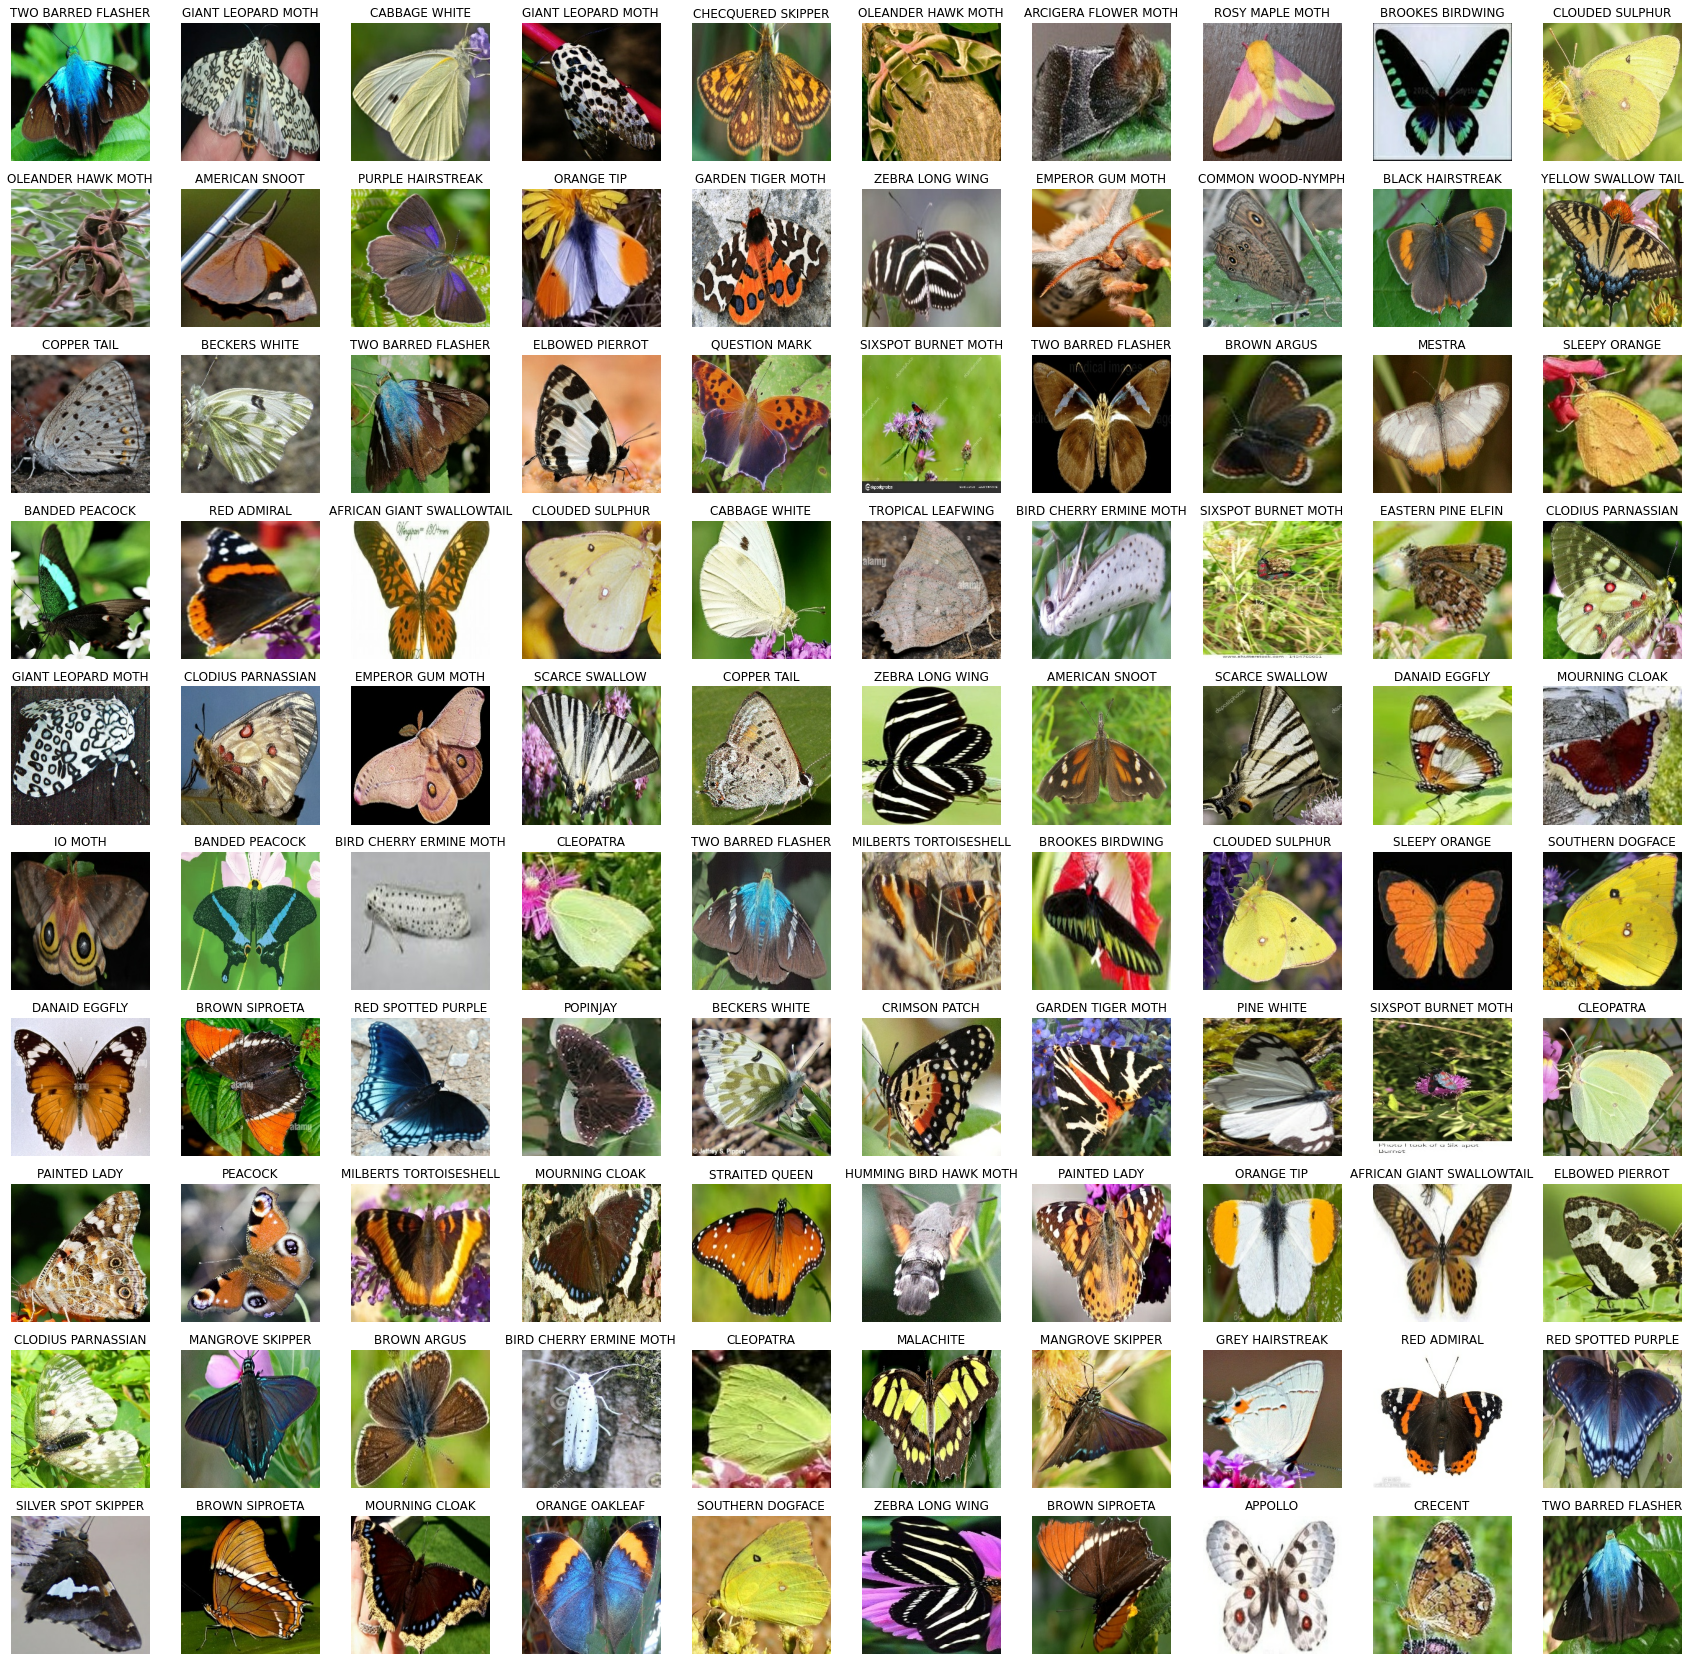

In [60]:
plt.figure(figsize=(30,30))
for images, labels in training_data.take(1):
    #print(labels)
    for j in range(100):
        axis = plt.subplot(10, 10, j + 1)
        plt.imshow(np.asarray(images[j]).astype("uint8"))
        plt.title(classes[labels[j]])
        plt.axis("off")

# Preprocessing

In [61]:
data_preprocessing = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    #layers.GaussianNoise(0.1),
    #tfio.experimental.filter.laplacian()
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)
])

In [62]:
training_data = training_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [63]:
INPUT_SHAPE = (128, IMAGE_SIZE, IMAGE_SIZE, 3)
model = models.Sequential([
    data_preprocessing,
    layers.Conv2D(128, (3,3), activation = 'relu', input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16, (3,3), activation = 'relu'),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    #layers.Dense(units = 500, activation = 'relu'),
    layers.Dense(units = 100, activation = 'sigmoid')
])

In [64]:
model.build(input_shape = INPUT_SHAPE)

In [65]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [66]:
model.fit(training_data, batch_size = BATCH_SIZE, validation_data = validation_data, epochs = 10)

Epoch 1/10
99/99 [==============================] - 64s 609ms/step - loss: 4.1955 - accuracy: 0.0599 - val_loss: 3.5669 - val_accuracy: 0.1440
Epoch 2/10
99/99 [==============================] - 50s 504ms/step - loss: 3.1794 - accuracy: 0.2145 - val_loss: 2.9221 - val_accuracy: 0.2800
Epoch 3/10
99/99 [==============================] - 49s 498ms/step - loss: 2.5734 - accuracy: 0.3378 - val_loss: 2.3511 - val_accuracy: 0.4020
Epoch 4/10
99/99 [==============================] - 49s 496ms/step - loss: 2.2264 - accuracy: 0.4231 - val_loss: 2.0338 - val_accuracy: 0.4700
Epoch 5/10
99/99 [==============================] - 49s 498ms/step - loss: 2.0078 - accuracy: 0.4726 - val_loss: 1.8549 - val_accuracy: 0.5120
Epoch 6/10
99/99 [==============================] - 49s 498ms/step - loss: 1.8462 - accuracy: 0.5129 - val_loss: 1.6747 - val_accuracy: 0.5800
Epoch 7/10
99/99 [==============================] - 49s 496ms/step - loss: 1.7192 - accuracy: 0.5436 - val_loss: 1.6215 - val_accuracy: 0.5660

In [67]:
def getTestingAccuracy(model, testing_data):
    # getting the predictions from the model
    predicted_classes = model.predict(testing_data).argmax(axis=1)
    
    # converting the numerical predictions to the class names for ease of life
    predicted_class_names = [classes[x] for x in predicted_classes]
    
    # getting the actual class names from the testing dataset
    actual_classes = []
    for images, labels in testing_data:
        for label in labels:
            actual_classes.append(classes[label])

    # put the actual labels and the predicted data into a single dataframe to evaluate the results
    testing_df = pd.DataFrame()
    testing_df['actual'] = actual_classes
    testing_df['predictions'] = predicted_class_names

    # defining a function to provide to the lamba function to check for accuracy
    def isCorrect(actual, target):
        return actual == target

    # creating a column and storing if the actual labels and the predicted labels match
    testing_df['correct'] = testing_df.apply(lambda x: isCorrect(x.actual, x.predictions), axis=1)
                                             
    # returning the accuracy
    print("Accuracy on testing data:", (sum(testing_df.correct)/len(predicted_class_names))*100, "%")                                          
    return (sum(testing_df.correct)/len(predicted_class_names))
    

In [68]:
getTestingAccuracy(model, testing_data)

16/16 [==============================] - 1s 49ms/step
Accuracy on testing data: 61.4 %


0.614